## Data Visualization in BlazingSQL Notebooks

In [1]:
from blazingsql import BlazingContext

# connect to BlazingSQL w/ BlazingContext API
bc = BlazingContext()

BlazingContext ready


In [2]:
import os

# identify path to data directory
data_dir = f'{os.getcwd().split("/intro_notebooks")[0]}/data'

# create a BlazingSQL table from any file w/ .create_table(table_name, file_path)
bc.create_table('taxi', f'{data_dir}/sample_taxi.csv', header=0)

### Matplotlib 

[GitHub](https://github.com/matplotlib/matplotlib) | [Welcome Notebook](../welcome.ipynb#Matplotlib)

In [3]:
# matplotlib/seaborn on a .to_pandas() gdf
df = bc.sql('SELECT * FROM taxi').to_pandas()

corr = df.corr()

corr.style.background_gradient(cmap='coolwarm')

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
VendorID,1,0.299742,-0.00132903,-0.00977762,-0.0112657,0.00175996,0.00988121,0.00692277,-0.0117453,0.00217687,0.242798,-0.000436702,0.00796707,0.00762232,0.00216507,0.00615316
passenger_count,0.299742,1,-0.000553125,-0.00516744,0.0131011,0.00738508,0.00684952,0.00529868,-0.0111071,0.00391433,0.0458663,0.00436833,-0.00211478,-0.00232565,-0.00121632,-0.000283777
trip_distance,-0.00132903,-0.000553125,1,0.00102591,-0.000698798,0.0159808,-0.000333643,5.56622e-05,0.00871679,0.00981547,0.000102859,0.0159401,0.00517996,-0.000454872,0.00744814,0.00167076
RatecodeID,-0.00977762,-0.00516744,0.00102591,1,-0.000590712,0.062974,-0.0124544,-0.190843,0.0269015,0.045547,-0.00414398,0.060851,0.00446507,-0.00245536,-0.00789674,-0.00132013
payment_type,-0.0112657,0.0131011,-0.000698798,-0.000590712,1,-0.0961275,-0.0313527,-0.0458749,-0.595002,-0.0458035,-0.0463016,-0.212781,0.0344114,0.0653233,0.0439404,0.0649564
fare_amount,0.00175996,0.00738508,0.0159808,0.062974,-0.0961275,1,-0.00585413,-0.0816051,0.501594,0.480711,0.00168625,0.973958,0.234968,-0.0282738,0.280641,-0.0507077
extra,0.00988121,0.00684952,-0.000333643,-0.0124544,-0.0313527,-0.00585413,1,0.0406312,0.0334733,-0.0206284,0.0345444,0.0443768,-0.0319038,-0.0525884,0.021845,-0.0223311
mta_tax,0.00692277,0.00529868,5.56622e-05,-0.190843,-0.0458749,-0.0816051,0.0406312,1,-0.0300559,-0.0757462,0.00586908,-0.0754526,-0.00242349,0.00384593,0.0166294,0.00271048
tip_amount,-0.0117453,-0.0111071,0.00871679,0.0269015,-0.595002,0.501594,0.0334733,-0.0300559,1,0.353614,0.0264519,0.663295,0.139598,-0.0377305,0.122896,-0.0584887
tolls_amount,0.00217687,0.00391433,0.00981547,0.045547,-0.0458035,0.480711,-0.0206284,-0.0757462,0.353614,1,0.00263769,0.574899,0.363445,0.0679587,0.247424,0.0393681


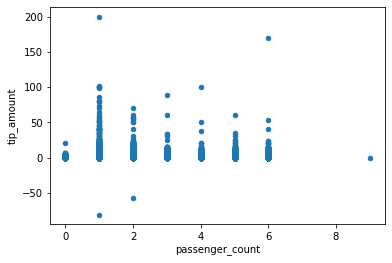

In [14]:
df.plot(kind='scatter', 
        x='passenger_count', 
        y='tip_amount')

### Datashader
    
[GitHub](https://github.com/holoviz/datashader/) | [Welcome Notebook](../welcome.ipynb#Datashader)

In [ ]:
import datashader as ds
from colorcet import fire

# execute query & lay out a canvas w/ dropoff locations 
nyc = ds.Canvas().points(bc.sql('SELECT dropoff_x, dropoff_y FROM taxi'), 'dropoff_x', 'dropoff_y')

# shade in the picture w/ fire & display
ds.transfer_functions.set_background(ds.transfer_functions.shade(nyc, cmap=fire), "black")